---
**License**

 gauss_constraint_mcmc

 Mon Jun 26 17:30:00 2023\
 Copyright  2023\
 Sandro Dias Pinto Vitenti  <vitenti@uel.br>

---
---

 gauss_constraint_mcmc\
 Copyright (C) 2023 Sandro Dias Pinto Vitenti  <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
import sys

from numcosmo_py import Ncm

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import math

import getdist
from getdist import plots
from getdist import MCSamples

from numcosmo_py.experiments.gauss_constraint import run_gauss_constraint_mcmc

from numcosmo_py.plotting.tools import confidence_ellipse
from numcosmo_py.plotting.tools import set_rc_params_article
from numcosmo_py.plotting.getdist import mcat_to_mcsamples
from numcosmo_py.sampling.esmcmc import mcat_print_info

In [2]:
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

nthreads = 4
nwalkers = 30000
burnin = 49
thin = 1
dim = 50
save_figs = True

Ncm.func_eval_set_max_threads(nthreads)
Ncm.func_eval_log_pool_stats()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      4


In [3]:
catalog_apes = f"gauss_constraint_{dim}d_mcmc_catalog_WalkerTypes.APES_{nwalkers}.fits"
catalog_tmvn = run_gauss_constraint_mcmc(
    sampler="apes",
    nwalkers=nwalkers,
    dim=dim,
    ssize=1000000,
    tmvn=True
)
table_tmvn = np.loadtxt(catalog_tmvn)

                      1     0.0471515348525886      0.288684678159939     -0.237404588957029     -0.138601764742089    -0.0340508650068155     -0.402040635927229      0.094322033769404     -0.168290271154262    -0.0696317684666627      0.127593887269235     0.0236116272171087      0.110086699531913       0.19182922220237     0.0539307787477161      0.114851446427991     -0.247951611681888     -0.115546809782676    -0.0735187114681953     0.0176692459500944       -0.2358378985159      0.102028465783953     -0.238882581400788    -0.0272581558438458    -0.0954679624672535     -0.239257241694878     0.0733300547578315   -0.00581764413774122     0.0770682648847245     -0.173953451231175     -0.124633550716882     -0.165910632158846    -0.0152949008066491    0.00501074617779618     -0.047753386091037      -0.32539763810969     0.0756280007550441       0.21726548922785    -0.0721041356490025     -0.189021800298894      0.427793296622547      -0.14709120336216      0.309480169203243     -0.282

      0.094322033769404      0.169117173716534      -0.24252323485727     -0.193596563898914     0.0487647871994856     -0.123446250554503        0.1136484567454                      1      0.130399420382499     -0.330239370644835     -0.105336112654994      -0.13928224373539    -0.0303825877823411      0.276838573933687    -0.0288947405332877      -0.30178202998996      0.104370289610549     -0.280519495715853      0.304463725850322     0.0356104982013526    -0.0155133266079887      0.391521771556701     0.0966571634597003     0.0295124111716494     0.0921952359568603    -0.0689298926348844      0.251744023866689     -0.195066805976673      0.231814049929822      0.315340620325183      0.353981563373238      0.336774338962821     -0.122410264300062     0.0750274034823998     0.0816287921543715     -0.107116573817803      0.096582627335171     0.0928422457509679     0.0785848578263965     -0.328094200018838     -0.144349499243877     -0.119783044007288      0.201779614683962    -0.0606

     0.0539307787477161     -0.223880939543197    0.00947395422837754     0.0430186216709152     -0.240199568997515     -0.298421121155459    -0.0918416336282034    -0.0288947405332877    -0.0310749936879062      0.149769857504267      0.315394704236372     0.0309049955022298      0.212057410172258    -0.0191013173378485                      1     0.0801835131271733      0.182447305283263      0.129283001595133     0.0849789092822194     0.0154825117729237     -0.117164656476961     0.0290129481378222    -0.0685868664818624     -0.085024853531691    -0.0537775083522077     0.0803088748236909       0.26032708122048      0.106630380011874      0.304018418073987    -0.0186033996700093    0.00300261556407413     -0.248018613974879     -0.250329970562466     -0.192298255885207      0.273077612364818      0.123584090754387      0.302980555005341    -0.0561296430782989      0.222756352381769     0.0123039419969783    0.00319847868351554     0.0334752157948218      -0.17202162923466     0.0110

      0.102028465783953     0.0255628504676719     -0.507768556713689    -0.0369197424051282    -0.0798142094596037   -0.00370659470417417     0.0387165609802433      0.391521771556701      0.103730255650561     -0.161612951975662      0.122423815126464    -0.0675944057237185     -0.100008954864218     -0.213792217248182     0.0290129481378222     -0.275898210392061     -0.028395215775492     -0.361660799331711      0.106820399171676       0.12283905635626      0.173937395467078                      1     0.0678767301645803    0.00562974153037444      0.139577627991701     0.0542647497155719      0.315995013229965      0.201472651273653     0.0832272188276072       0.11493590329225     0.0373722373511691   -0.00107269210639921    -0.0180548657215665      0.203317882632543      0.209703156357381      0.198465295133677     0.0809326725679863     0.0199293184789329     -0.184568050504681     -0.343047647202839      0.136805545576575    -0.0968705201210877    -0.0294265091782768      -0.10

     0.0770682648847245    -0.0493437486228638     -0.105177145659964     -0.475478255049139     0.0930951471111793      -0.23463385826101    -0.0773178712371862      0.231814049929822      0.308630235905905  -0.000920206019881045      0.119639669816136    -0.0511493159246598     0.0565144136226846    -0.0515663701827778      0.304018418073987      0.168682658446304       0.23761443693347    -0.0265030729446524     0.0656395851348758     -0.281803650803783     -0.384762997348857     0.0832272188276072     -0.277130825030125     0.0465457704221966    -0.0708729754114166      0.233638808194554      0.160785252531472     -0.133404997198029                      1     0.0188960251135726      0.271196156696647    0.00168028785767963     -0.296169389290225    -0.0445697719943246      0.185845717619244      0.173789042306845      0.167570879451995      0.220381763846148     0.0342237828499684     -0.154185160404556    -0.0321071861624138     -0.207895751084655      0.261796686348383    0.00021

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
mcat_apes = Ncm.MSetCatalog.new_from_file_ro(catalog_apes, nwalkers * burnin)

assert mcat_apes.nchains() == nwalkers

In [5]:
mset = mcat_apes.peek_mset()
mmvnd = mset.peek(Ncm.ModelMVND.id())
for i in range(dim):
    mmvnd.param_peek_desc(i).props.symbol = fr"x_{{{i+1}}}"

In [6]:
sample_apes, rows_apes, posterior_apes = mcat_to_mcsamples(
    mcat_apes,
    "APES",
    collapse=True,
)

Removed no burn in


In [7]:
names = [pn.name for pn in sample_apes.paramNames.names]
labels = [pn.label for pn in sample_apes.paramNames.names]

posterior_tmvn = 0.5 * table_tmvn[:, 0]
rows_tmvn = np.delete(table_tmvn, 0, 1)

sample_tmvn = MCSamples(
    samples=rows_tmvn, 
    loglikes=posterior_tmvn, 
    names=names, 
    labels=labels, 
    label="TMVN"
)

Removed no burn in


/tmp/ipykernel_1478231/2749038692.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


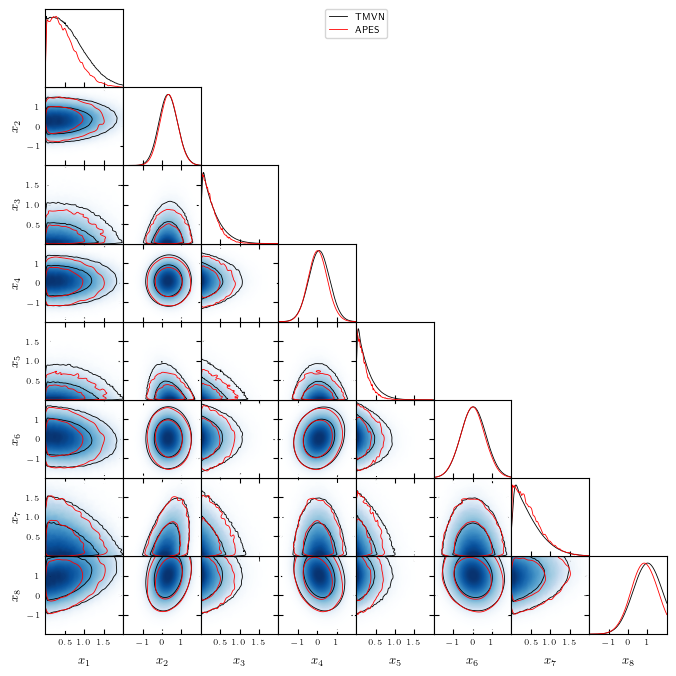

In [8]:
set_rc_params_article(ncol=2)

nparams = 8
indices = range(0, nparams)
indices_odd = range(nparams, 2 * nparams, 2)
params = [f"x_{i+1}" for i in indices]

param_limits = {f"x_{i+1}": [0.0 if i % 2 == 0 else -2.0, 2.0] for i in indices}

g = plots.get_subplot_plotter(
    width_inch=plt.rcParams["figure.figsize"][0],
)
g.settings.linewidth = 0.01
g.triangle_plot(
    [sample_tmvn, sample_apes],
    shaded=True,
    params=params,
    param_limits=param_limits,
    diag1d_kwargs={'nbands': 3}
)

if save_figs:
    plt.tight_layout()
    plt.savefig(f"gauss_constraint_{dim}d_corner.pdf")

In [9]:
kernel = Ncm.StatsDistKernelST.new(dim, 1.0)
interp_vkde = Ncm.StatsDistVKDE.new(kernel, Ncm.StatsDistCV.NONE)
interp_kde = Ncm.StatsDistKDE.new(kernel, Ncm.StatsDistCV.NONE)

# interp_vkde.set_cov_type(Ncm.StatsDistKDECovType.ROBUST)
# interp_kde.set_cov_type(Ncm.StatsDistKDECovType.ROBUST)
interp_vkde.set_over_smooth(1.1)
interp_kde.set_over_smooth(0.2)

row_kde = rows_tmvn
posterior_kde = posterior_tmvn
label_kde = "tmvn"

In [10]:
max_n = len(row_kde)
ssize = int(nwalkers / 2)

interp_vkde.reset()
interp_kde.reset()

for theta in row_kde[-ssize:]:
    theta_v = Ncm.Vector.new_array(theta)
    interp_vkde.add_obs(theta_v)
    interp_kde.add_obs(theta_v)

m2lnL_v = Ncm.Vector.new_array(2.0 * posterior_kde[-ssize:])

interp_vkde.prepare_interp(m2lnL_v)
interp_kde.prepare_interp(m2lnL_v)

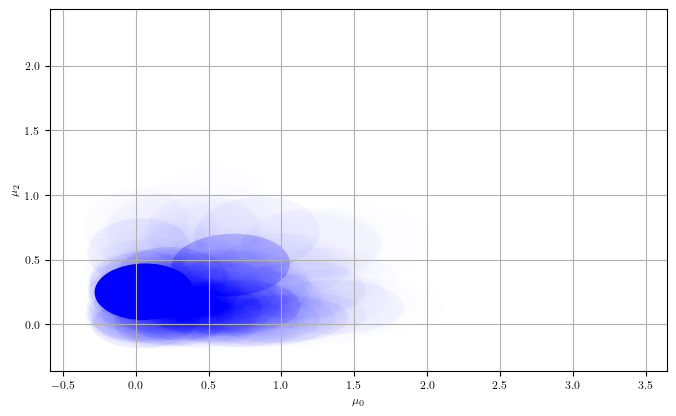

In [11]:
set_rc_params_article(ncol=2)
fig, ax = plt.subplots(1, 1)

weights = np.array(interp_vkde.peek_weights().dup_array())
weights = weights / np.sum(weights)
lnweights = np.log(weights)

lnweights = lnweights - np.min(lnweights)
lnweights = lnweights / np.max(lnweights)

pair = [0, 2]
max_w = interp_vkde.peek_weights().get_max()


for i in range(interp_vkde.get_sample_size()):
    y_i, cov_i, n_i, w_i = interp_vkde.get_Ki(i)
    mu = np.array(y_i.dup_array())[pair]
    cov = np.array([[cov_i.get(i, j) for j in pair] for i in pair])
    cov = cov * 1.0
    confidence_ellipse(mu, cov, ax, facecolor="blue", alpha=w_i/max_w)

ax.set_xlabel("$\mu_0$")
ax.set_ylabel("$\mu_2$")
ax.autoscale_view()
plt.grid()

if save_figs:
    plt.tight_layout()
    plt.savefig(f"gauss_constraint_{dim}d_{label_kde}_vkde_kernels.pdf")

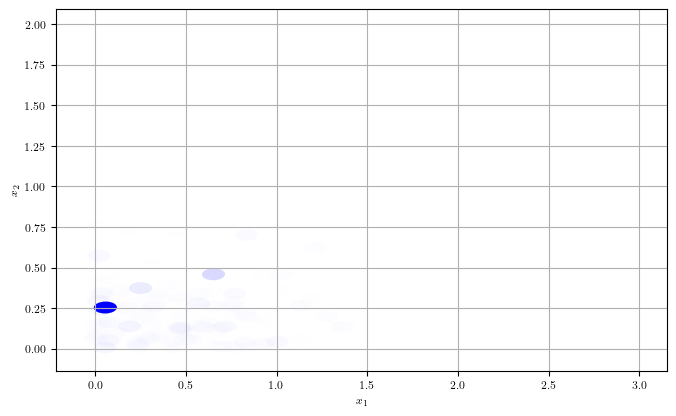

In [12]:
set_rc_params_article(ncol=2)
fig, ax = plt.subplots(1, 1)

max_w = interp_kde.peek_weights().get_max()

for i in range(interp_kde.get_sample_size()):
    y_i, cov_i, n_i, w_i = interp_kde.get_Ki(i)
    mu = np.array(y_i.dup_array())[pair]
    cov = np.array([[cov_i.get(i, j) for j in pair] for i in pair])
    cov = cov * 1.0

    confidence_ellipse(mu, cov, ax, facecolor="blue", alpha=w_i/max_w)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.autoscale_view()
plt.grid()

if save_figs:
    plt.tight_layout()
    plt.savefig(f"gauss_constraint_{dim}d_{label_kde}_kde_kernels.pdf")

78.9842857471425
10.00218233179906
78.42451079784054
10.068375460809468


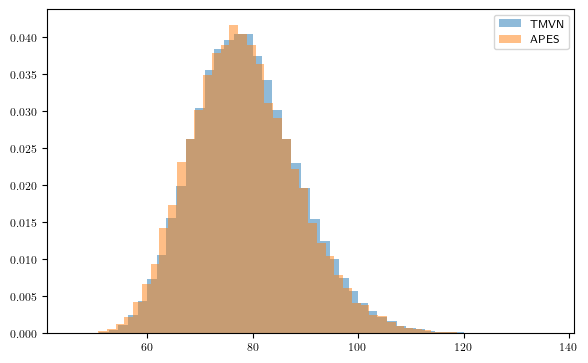

In [13]:
tmvn_mu = 2.0 * posterior_tmvn
print(np.mean(tmvn_mu))
print(np.std(tmvn_mu))
plt.hist(tmvn_mu, bins=50, density=True, alpha=0.5, label="TMVN")

apes_mu = 2.0 * posterior_apes
print(np.mean(apes_mu))
print(np.std(apes_mu))
plt.hist(apes_mu, bins=50, density=True, alpha=0.5, label="APES")

plt.legend(loc='best')

pass